In [6]:
import branca.colormap as cm
import folium
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
from pandas import DataFrame
from scipy.interpolate import PchipInterpolator

In [2]:
# データのインポート
df_time_series_10s = pd.read_csv('/content/result_by_optimizationModelWithCupy_50_10s.csv')
df_time_series_1m = pd.read_csv('/content/result_by_optimizationModelWithCupy_50.csv')
df_time_series_5m = pd.read_csv('/content/result_by_optimizationModelWithCupy_50_5m.csv')

print(df_time_series_10s.info())
print(df_time_series_1m.info())
print(df_time_series_5m.info())

df_time_series = [
    df_time_series_10s,
    df_time_series_1m,
    df_time_series_5m
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7910 entries, 0 to 7909
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             7910 non-null   int64  
 1   time                   7910 non-null   object 
 2   matching_success_rate  7910 non-null   float64
 3   bikes_occupied_rate    7910 non-null   float64
 4   rebalance_cost         7910 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 309.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1440 non-null   int64  
 1   time                   1440 non-null   object 
 2   matching_success_rate  1440 non-null   float64
 3   bikes_occupied_rate    1440 non-null   float64
 4   rebalance_cost         1440 non-null  

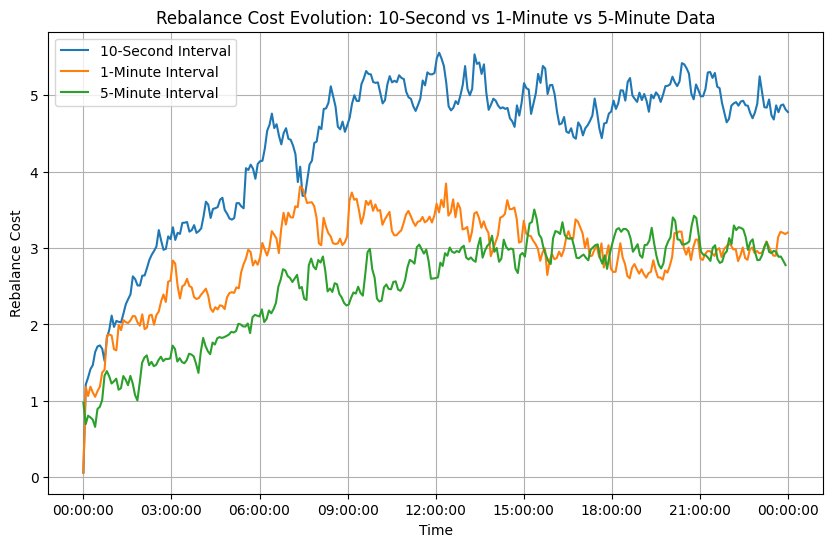

In [10]:
# それぞれのdf_time_serieのrebalance_costカラムの推移を比較する図をプロットする

# まず'time'カラムをdatetimeオブジェクトに変換する。
df_time_series_10s['time'] = pd.to_datetime(df_time_series_10s['time']) # Convert 'time' column to datetime for df_time_series_10s
df_time_series_1m['time'] = pd.to_datetime(df_time_series_1m['time'])
df_time_series_5m['time'] = pd.to_datetime(df_time_series_5m['time']) # Convert 'time' column to datetime for df_time_series_5m

# datetime64[ns]をUnixタイムスタンプ（秒）に変換
time_10s = df_time_series_10s['time'].values.astype(np.int64) / 1e9 # Extract time values from df_time_series_10s
time_1m = df_time_series_1m['time'].values.astype(np.int64) / 1e9
time_5m = df_time_series_5m['time'].values.astype(np.int64) / 1e9 # Extract time values from df_time_series_5m


# 補間のための新しい時間データを作成 - 各データフレームの時間範囲で個別に作成
time_new_10s = np.linspace(time_10s.min(), time_10s.max(), 300) # Create time_new for df_time_series_10s
time_new_1m = np.linspace(time_1m.min(), time_1m.max(), 300)
time_new_5m = np.linspace(time_5m.min(), time_5m.max(), 300) # Create time_new for df_time_series_5m


# PCHIP補間 - 各データフレームに対して個別に実行
pchip_rebalance_cost_10s = PchipInterpolator(time_10s, df_time_series_10s['rebalance_cost']) # Use time_10s for interpolation
rebalance_cost_smooth_10s = pchip_rebalance_cost_10s(time_new_10s) # Use time_new_10s for interpolation

pchip_rebalance_cost_1m = PchipInterpolator(time_1m, df_time_series_1m['rebalance_cost'])
rebalance_cost_smooth_1m = pchip_rebalance_cost_1m(time_new_1m)

pchip_rebalance_cost_5m = PchipInterpolator(time_5m, df_time_series_5m['rebalance_cost']) # Use time_5m for interpolation
rebalance_cost_smooth_5m = pchip_rebalance_cost_5m(time_new_5m) # Use time_new_5m for interpolation

# プロット
fig, ax1 = plt.subplots(figsize=(10, 6))

# 新しい時間データをDateTimeに変換してプロット - 各データフレームの時間データを使用
time_new_datetime_10s = pd.to_datetime(time_new_10s * 1e9) # Convert time_new_10s to datetime
time_new_datetime_1m = pd.to_datetime(time_new_1m * 1e9)
time_new_datetime_5m = pd.to_datetime(time_new_5m * 1e9) # Convert time_new_5m to datetime

# 各モデルのリバランスコストの推移をプロット - 対応する時間データを使用
plt.plot(time_new_datetime_10s, rebalance_cost_smooth_10s, label='10-Second Interval') # Use time_new_datetime_10s
plt.plot(time_new_datetime_1m, rebalance_cost_smooth_1m, label='1-Minute Interval')
plt.plot(time_new_datetime_5m, rebalance_cost_smooth_5m, label='5-Minute Interval') # Use time_new_datetime_5m


# 軸ラベル、凡例、タイトルを設定
plt.xlabel('Time')
plt.ylabel('Rebalance Cost')
plt.legend()
plt.grid(True)
plt.title('Rebalance Cost Evolution: 10-Second vs 1-Minute vs 5-Minute Data')

# x 軸のフォーマットを「時:分:秒」のみに変更
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# グラフを表示
plt.show()